In [6]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import pickle


# Load the dataloaders
train_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'test_dataloader.pkl'), 'rb'))

for team_input, player_input, ball_input, labels, mask in train_dataloader:
    print(f"Team input shape: {team_input.shape}")  # [batch_size, team_feature_dim]
    print(f"Player input shape: {player_input.shape}")  # [batch_size, player_feature_dim]
    print(f"Padded ball input shape: {ball_input.shape}")  # [batch_size, max_seq_len, ball_feature_dim]
    print(f"Mask shape: {mask.shape}")  # [batch_size, max_seq_len]
    print(f"Labels shape: {labels.shape}")  # [batch_size]
    break

Team input shape: torch.Size([32, 13])
Player input shape: torch.Size([32, 22, 11])
Padded ball input shape: torch.Size([32, 271, 9])
Mask shape: torch.Size([32, 271])
Labels shape: torch.Size([32])


In [60]:
import polars as pl
i=31
data = pl.DataFrame(ball_input[i].numpy(),schema=["innings","ball","runs","wickets","overs","run_rate","curr_score","curr_wickets","target"])
label = labels[i].numpy()
print(label)
innings1 = data.filter(data['innings'] == 1)
innings2 = data.filter(data['innings'] == 2)

0.0


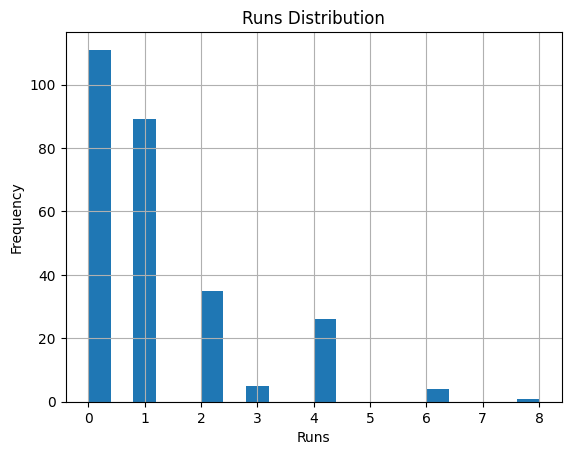

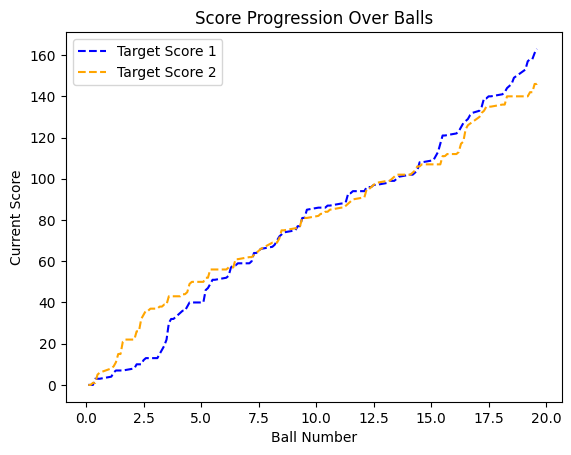

In [61]:
import matplotlib.pyplot as plt

# Visualize the distribution of runs per ball
data.select("runs").to_pandas().hist(bins=20)
plt.title("Runs Distribution")
plt.xlabel("Runs")
plt.ylabel("Frequency")
plt.show()

# Visualize the progression of score over balls

plt.plot(innings1.to_pandas()["ball"], innings1.to_pandas()["curr_score"], linestyle="--", color="blue", label="Target Score 1")
plt.plot(innings2.to_pandas()["ball"], innings2.to_pandas()["curr_score"], linestyle="--", color="orange", label="Target Score 2")

plt.title("Score Progression Over Balls")
plt.xlabel("Ball Number")
plt.ylabel("Current Score")
plt.legend()
plt.show()

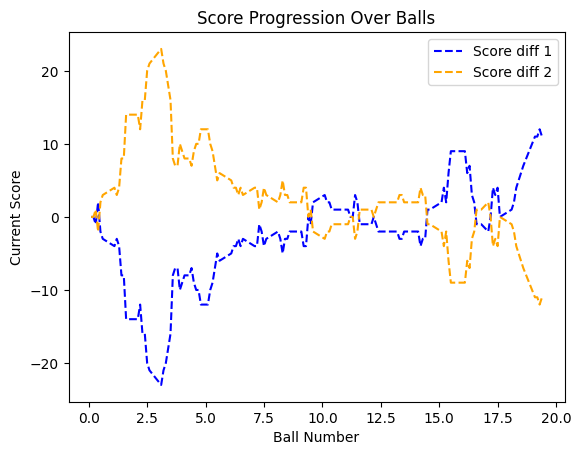

In [62]:
diff1 = innings1.to_pandas()["curr_score"] - innings2.to_pandas()["curr_score"]
diff2 = innings2.to_pandas()["curr_score"] - innings1.to_pandas()["curr_score"]
plt.plot(innings1.to_pandas()["ball"], diff1, linestyle="--", color="blue", label="Score diff 1")
plt.plot(innings1.to_pandas()["ball"], diff2, linestyle="--", color="orange", label="Score diff 2")
plt.title("Score Progression Over Balls")
plt.xlabel("Ball Number")
plt.ylabel("Current Score")
plt.legend()    
plt.show()